# **Research Project (Honours)**

###### *By Mahlatsi Malise Mashilo (202215639)*

### **Forecasting Car Sales in South Africa Using Google Search Data with Post-hoc Explainable AI**

This project aims to forecast national monthly car sales in South Africa (who: automotive industry stakeholders) by integrating historical vehicle sales data with behavioral signals from Google Trends search indices (what). Using data spanning from 2010 Jan to 2025 Jan (when) and focusing on the South African automotive market (where), the study addresses why traditional forecasting methods—based only on past sales—often fail to capture rapid shifts in consumer interest and external market changes. To overcome this, the research compares traditional time-series models (SARIMA, LSSVR) with deep learning models (LSTM, CNN-LSTM, BiLSTM), both with and without online search data, to evaluate the added predictive value of behavioral signals (how). Finally, the best-performing deep learning models are interpreted using SHAP analysis to reveal which features most influence forecasts, supporting more data-driven, transparent, and responsive decision-making for manufacturers, dealerships, and analysts.

#### **Datasets:**

<table style="width:100%">
  <thead>
    <tr>
      <th>Name</th>
      <th>Start Date</th>
      <th>End Date</th>
      <th>Source</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Motor Trade Sales.xlsx</td>
      <td>01-1998</td>
      <td>05-2025</td>
      <td>CEIC Data</td>
      <td>Revenue generated each month from sales</td>
    </tr>
    <tr>
      <td>Motor Vehicle Sales Monthly South Africa.xlsx</td>
      <td>01-2003</td>
      <td>06-2025</td>
      <td>CEIC Data</td>
      <td>Number of units sold each month</td>
    </tr>
    <tr>
      <td>Autos_Vehicles_Category.csv</td>
      <td>01-2004</td>
      <td>07-2025</td>
      <td>Google Trends</td>
      <td>The overall interest in the Autos Vehicles category on Google Trends</td>
    </tr>
    <tr>
      <td>Queries_Rising.csv</td>
      <td>01-2004</td>
      <td>07-2025</td>
      <td>Google Trends</td>
      <td>The currently rising queries related to the automotive category in Google Trends</td>
    </tr>
    <tr>
      <td>Queries_Top.csv</td>
      <td>01-2004</td>
      <td>07-2025</td>
      <td>Google Trends</td>
      <td>The currently top queries related to the automotive category in Google Trends</td>
    </tr>
    <tr>
      <td>Topic_Rising.csv</td>
      <td>01-2004</td>
      <td>07-2025</td>
      <td>Google Trends</td>
      <td>The currently rising topics related to the automotive category in Google Trends</td>
    </tr>
    <tr>
      <td>Topic_Top.csv</td>
      <td>01-2004</td>
      <td>07-2025</td>
      <td>Google Trends</td>
      <td>The currently top topics related to the automotive category in Google Trends</td>
    </tr>
  </tbody>
</table>


##### **Important Descriptions**
+ Interest over time from Google Trends:

    *Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means that there was not enough data for this term.*

## 1. Libraries

In [14]:
#! pip install pandas numpy matplotlib scikit-learn seaborn plotly statsmodels shap joblib openpyxl

# Tensorflow for CPU users
#! pip install tensorflow

In [ ]:
import pandas as pd, numpy as np, seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os, joblib
import openpyxl
import tensorflow as tf
import keras
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Deep learning
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Bidirectional
from keras.callbacks import EarlyStopping

# SARIMA, LSSVR
import statsmodels.api as sm
from sklearn.svm import SVR

## 2. Importing datasets

In [16]:
sales = pd.read_excel("Motor Trade Sales.xlsx", sheet_name="My Series")

vol = pd.read_excel("Motor Vehicle Sales Monthly South Africa.xlsx",  sheet_name="My Series")

In [17]:
print(sales.info())
print("="*50)
print(vol.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    329 non-null    datetime64[ns]
 1   Sales   329 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    270 non-null    datetime64[ns]
 1   Volume  270 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.3 KB
None


In [18]:
# Google trends data preperation
def load_and_merge_google_trends_data(folder_path):
    merged_df = None
    folder = Path(folder_path)
    
    for file in folder.glob("*.csv"):
        keyword = file.stem  # Get filename without extension
        df = pd.read_csv(file, skiprows=2)
        
        # Rename the value column using the keyword (assumes 2 columns: Month + keyword)
        if df.shape[1] > 1:
            df.columns = ['Month', keyword]
        else:
            continue  # skip malformed file

        # Merge into final dataset
        if merged_df is None:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on='Month', how='outer')

    # Optional: sort by Month
    if merged_df is not None:
        merged_df.sort_values('Month', inplace=True)
    
    return merged_df


# Example usage:
base_path = "./GoogleTrends"
output_dir = "./Processed_Trends"
os.makedirs(output_dir, exist_ok=True)

folders = {
    "queries_rising": os.path.join(base_path, "Queries", "Rising"),
    "queries_top": os.path.join(base_path, "Queries", "Top"),
    "topics_rising": os.path.join(base_path, "Topics", "Rising"),
    "topics_top": os.path.join(base_path, "Topics", "Top")
}

# Process and save
for name, path in folders.items():
    merged = load_and_merge_google_trends_data(path)
    if merged is not None:
        merged.to_csv(os.path.join(output_dir, f"{name}.csv"), index=False)
        print(f"Saved: {name}.csv")
    else:
        print(f"No data found for: {name}")

Saved: queries_rising.csv
Saved: queries_top.csv
Saved: topics_rising.csv
Saved: topics_top.csv


## 3. Data Preparation

   1. We will limit the range of observation to 01-2004 to 05-2025, since that is where they all overlap. (This will act as a form of balancing the datasets)
   2. Make sure the "Date" column is in datetime format, and is the index of the dataframe.
   3. Shift the days to the last of the month

In [19]:
def limit_date_range(df, date_column):
    # Replace "<1" values (strings) with 0 across all columns
    df.replace("<1", 0, inplace=True)
    # Convert to datetime
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce', format='%Y-%m')
    # Shift dates to end of month
    df[date_column] = df[date_column].dt.to_period('M').dt.to_timestamp('M')
    # Define boundaries
    start_date = pd.to_datetime('2004-01')
    end_date = pd.to_datetime('2025-05')
    # Filter by date range
    df = df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]
    return df


sales = limit_date_range(sales, 'Date')
vol = limit_date_range(vol, 'Date')

# Path to the folder
folder_path = "./Processed_Trends"
os.makedirs(folder_path, exist_ok=True)

# Apply filter to all CSVs in folder
for file in Path(folder_path).glob("*.csv"):
    try:
        df = pd.read_csv(file)
        # Rename 'Month' column to 'Date'
        if 'Month' in df.columns:
            df.rename(columns={'Month': 'Date'}, inplace=True)
        # Limit date range
        df_filtered = limit_date_range(df, 'Date')
        
        # Save the filtered dataframe
        out_file = Path(folder_path) / file.name
        df_filtered.to_csv(out_file, index=False)
        print(f"Filtered and saved: {out_file.name}")
    except Exception as e:
        print(f"Failed to process {file.name}: {e}")

Filtered and saved: queries_rising.csv
Filtered and saved: queries_top.csv
Filtered and saved: topics_rising.csv
Filtered and saved: topics_top.csv


In [20]:
# Here will will set the index of sales and vol dataframes to 'Date'
sales.set_index("Date", inplace=True)
vol.set_index("Date", inplace=True)

In [21]:
# Combining both series into one DataFrame
combined_df = pd.concat([
    sales.rename(columns={sales.columns[0]: 'Sales (Rmn)'}),
    vol.rename(columns={vol.columns[0]: 'Volume'})
], axis=1)

# Reset index to get date as a column
combined_df = combined_df.reset_index().rename(columns={'index': 'Date'})

# Melt to long format for seaborn lineplot
long_df = combined_df.melt(id_vars='Date', value_vars=['Sales (Rmn)', 'Volume'], 
                           var_name='Type', value_name='Value')

## 4. Data Understanding

### a. Time Series Plots

#### (i) Sales and Volume Time Series Plots

In [22]:
# Create interactive Plotly line chart
fig = px.line(
    long_df,
    x='Date',
    y='Value',
    color='Type',
    title='Sales and Volume Over Time',
    labels={'Value': 'Value/Count', 'Date': 'Date', 'Type': 'Legend'}
)

# Optional: Style tweaks
fig.update_layout(
    template='plotly_white',
    legend_title_text='Type',
    xaxis_title='Date',
    yaxis_title='Value/Count'
)

# Show the plot
fig.show()


##### *Interpretation:*

The graph shows an overall increase in sales (in millions) over the year with the volume of vehicles sold remaining in the 20-60 thousand range. In the early 2000's the volume of vehicles sold was more than the money generated, and it started maintaing the same trend up until 2016. After this the industry started focusing on maximizing profit. 

In early 2020, there was a sharp decline in both sales and volume. This was caused by the shut down of the country due to the Covid-19 Pandemic.[https://www.cars.co.za/motoring-news/new-car-sales-in-sa-march-2020/77385/]

**Key Takeaway:**
The outputs have a clear outlier during the early days of Covid so we will need to remedy that at some point.

#### (ii) Google Trends Time Series Plots

In [23]:
# Path to the folder
folder_path = "./Processed_Trends"
os.makedirs(folder_path, exist_ok=True)

# Apply filter and plot all CSVs
for file in Path(folder_path).glob("*.csv"):
    try:
        # Load the CSV and parse the index as datetime
        df = pd.read_csv(file, index_col=0, parse_dates=True)

        # Reset index to make 'Date' a column for Plotly
        df_reset = df.reset_index().rename(columns={df.index.name: 'Date'})

        # Melt to long format
        df_melted = df_reset.melt(id_vars='Date', var_name='Keyword', value_name='Interest')

        # Plot with Plotly
        fig = px.line(
            df_melted,
            x='Date',
            y='Interest',
            color='Keyword',
            title=f"{file.stem} Trends",
            labels={'Interest': 'Interest Level', 'Date': 'Date', 'Keyword': 'Keyword'}
        )

        fig.update_layout(
            template='plotly_white',
            legend_title_text='Keyword',
            xaxis_title='Date',
            yaxis_title='Interest Level'
        )

        fig.show()

    except Exception as e:
        print(f"Failed to plot {file.name}: {e}")

##### *Interpretation:*

So far all the graphs for the Google trends data is nonsensical, we will have to dig deeper at a later stage to extract some information from them.

### b. STL Plots for Sales and Volume

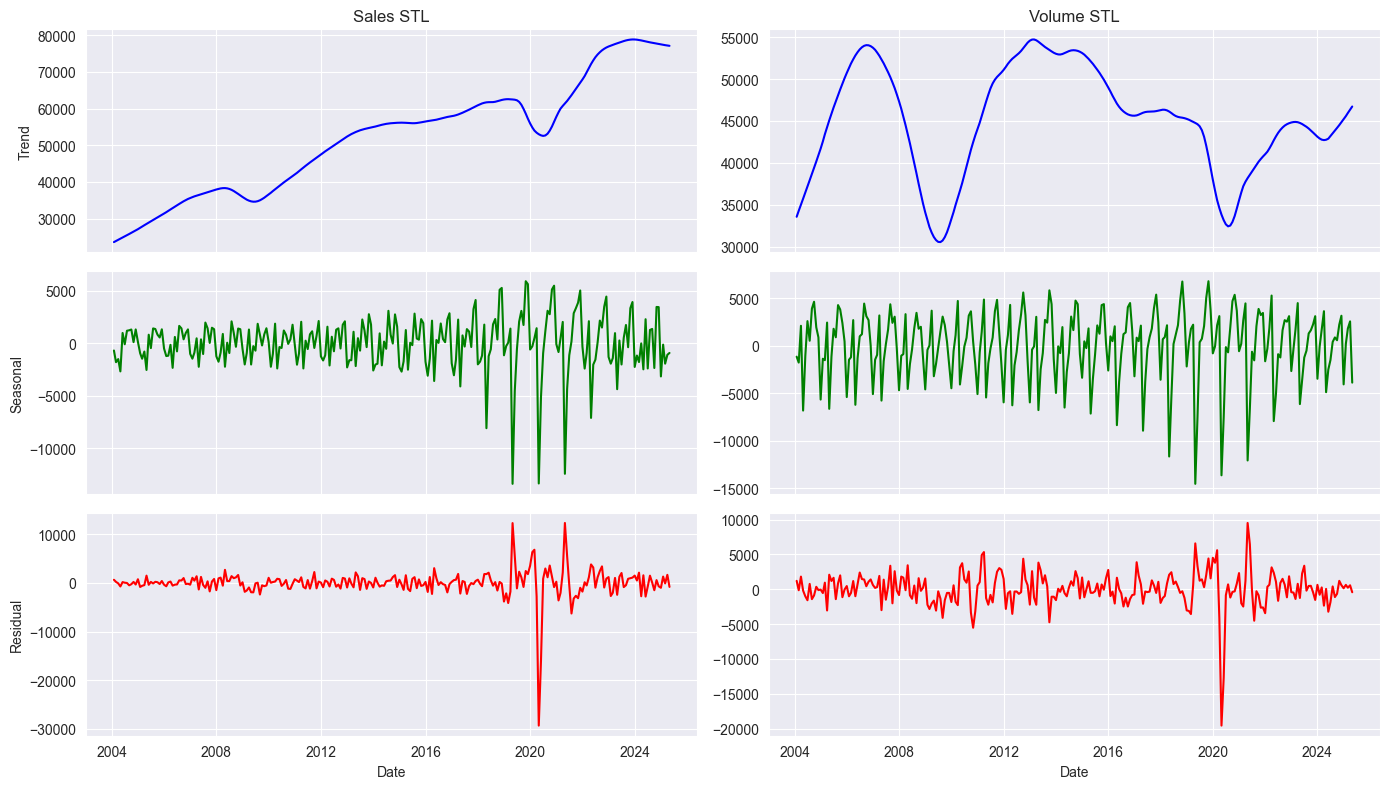

In [24]:
# Perform STL decomposition
stl_sales = STL(sales['Sales'], period=12).fit()
stl_vol = STL(vol['Volume'], period=12).fit()

# Create side-by-side subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 8), sharex=True)

# Titles for each subplot column
axes[0, 0].set_title('Sales STL')
axes[0, 1].set_title('Volume STL')

# Plot Trend
axes[0, 0].plot(stl_sales.trend, label='Trend', color='blue')
axes[0, 1].plot(stl_vol.trend, label='Trend', color='blue')

# Plot Seasonal
axes[1, 0].plot(stl_sales.seasonal, label='Seasonal', color='green')
axes[1, 1].plot(stl_vol.seasonal, label='Seasonal', color='green')

# Plot Residual
axes[2, 0].plot(stl_sales.resid, label='Residual', color='red')
axes[2, 1].plot(stl_vol.resid, label='Residual', color='red')

# Y-axis labels
axes[0, 0].set_ylabel('Trend')
axes[1, 0].set_ylabel('Seasonal')
axes[2, 0].set_ylabel('Residual')

# X-axis label on bottom row
axes[2, 0].set_xlabel('Date')
axes[2, 1].set_xlabel('Date')

# Tight layout
plt.tight_layout()
plt.show()


##### **Intepretation:**

<table style="width:100%; border-collapse: collapse;" border="1">
  <thead>
    <tr>
      <th style="padding:8px;"><strong>Component</strong></th>
      <th style="padding:8px;"><strong>Sales</strong></th>
      <th style="padding:8px;"><strong>Volume</strong></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding:8px;"><strong>Trend</strong></td>
      <td style="padding:8px;">
        There’s a clear upward trend from 2004 to around 2015, followed by a plateau between 2015–2018.
        A sharp dip is observed in 2020 (COVID-19), with strong recovery post-2021 and slight softening at the end.
      </td>
      <td style="padding:8px;">
        Starts high, rises until ~2006, then declines to 2009. Stabilizes between 2010–2016,
        then dips sharply in 2020 (pandemic) with partial recovery after. More volatile than Sales.
      </td>
    </tr>
    <tr>
      <td style="padding:8px;"><strong>Seasonality</strong></td>
      <td style="padding:8px;">
        Strong and consistent annual cycles. Peaks and troughs repeat regularly with slightly amplified fluctuations post-2019.
      </td>
      <td style="padding:8px;">
        Seasonal swings are more intense than in Sales. Regular cycles persist but become more erratic post-2020.
      </td>
    </tr>
    <tr>
      <td style="padding:8px;"><strong>Residuals</strong></td>
      <td style="padding:8px;">
        Mostly stable around zero, with outliers during 2020 (COVID shock). Suggests low noise and well-behaved time series.
      </td>
      <td style="padding:8px;">
        Similar residual shape as Sales, but with slightly higher volatility and noise, especially post-2018.
        Strong outliers in 2020.
      </td>
    </tr>
  </tbody>
</table>


### c. ACF/PACF Plots for volume and sales

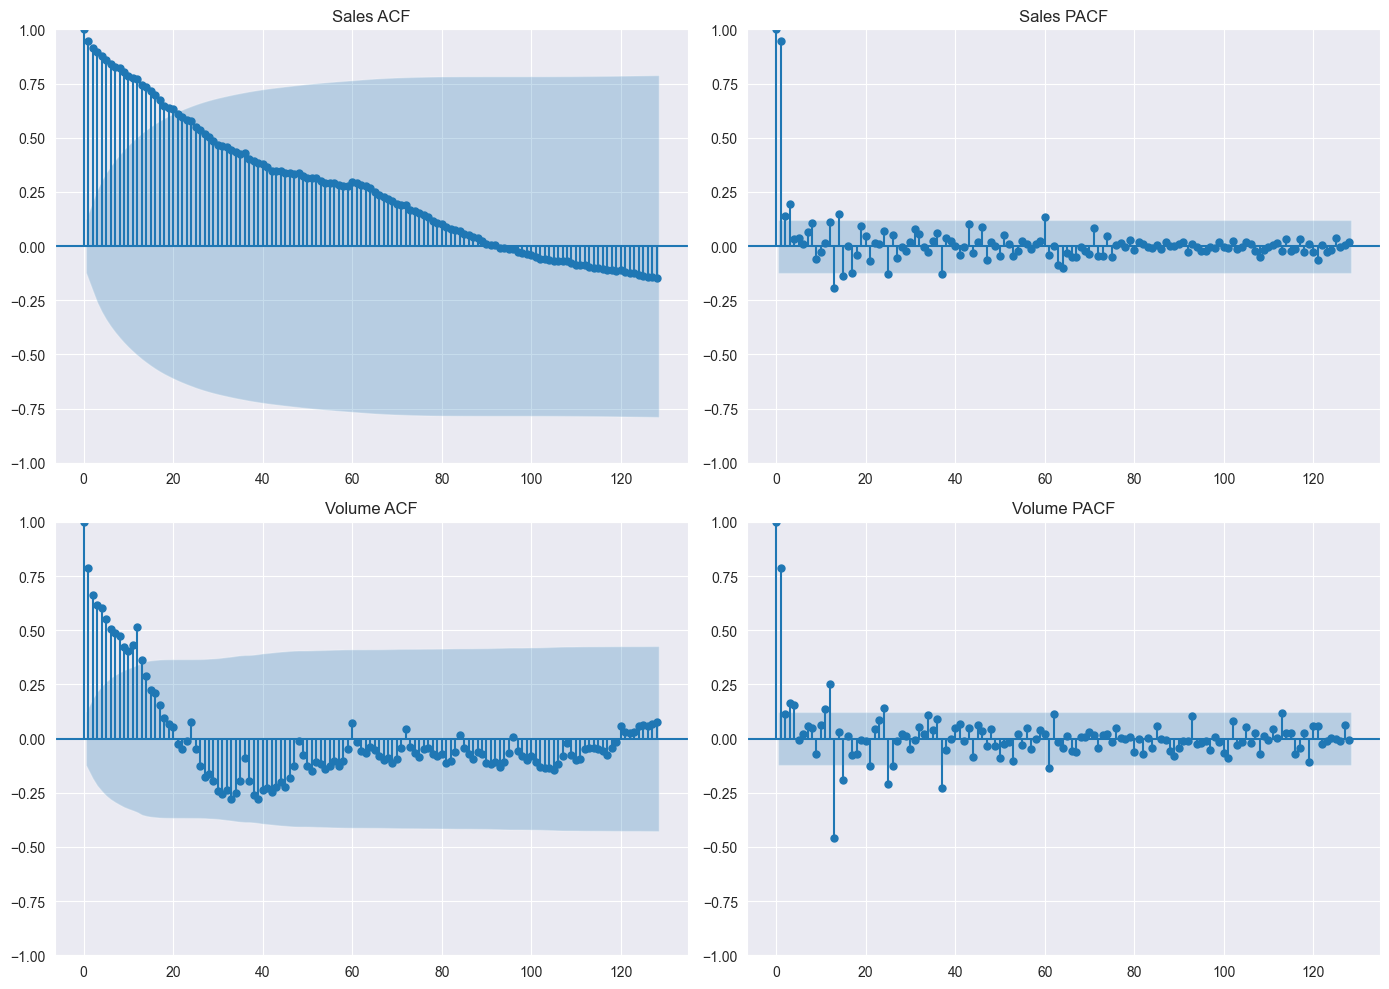

In [25]:
# Assuming sales and vol are DataFrames with one column each:
sales_series = sales["Sales"]
vol_series = vol["Volume"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sales ACF
plot_acf(sales_series, ax=axes[0, 0], lags=len(vol)//2)
axes[0, 0].set_title('Sales ACF')

# Sales PACF
plot_pacf(sales_series, ax=axes[0, 1], lags=len(vol)//2, method='ywm')
axes[0, 1].set_title('Sales PACF')

# Volume ACF
plot_acf(vol_series, ax=axes[1, 0], lags=len(vol)//2)
axes[1, 0].set_title('Volume ACF')

# Volume PACF
plot_pacf(vol_series, ax=axes[1, 1], lags=len(vol)//2, method='ywm')
axes[1, 1].set_title('Volume PACF')

plt.tight_layout()
plt.show()

##### **Intepretation:**

<table style="width:100%; border-collapse: collapse;" border="1">
  <thead>
    <tr>
      <th style="padding:8px;"><strong>Component</strong></th>
      <th style="padding:8px;"><strong>ACF</strong></th>
      <th style="padding:8px;"><strong>PACF</strong></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding:8px;"><strong>Sales</strong></td>
      <td style="padding:8px;">
        There is a High Positive Autocorrelation at at very low lags then slowly declining toward zero. This suggests that current sales vales are heavily dependent on previous sales values (Non-Stationarity)
      </td>
      <td style="padding:8px;">
        There is a large spike at lag 1, followed by much smaller spikes within confidence bounds. This indicates that lag 1 has the strongest direct effect on current sales once other lags are controlled for.
      </td>
    </tr>
    <tr>
      <td style="padding:8px;"><strong>Volume</strong></td>
      <td style="padding:8px;">
        There is a High Positive Autocorrelation at low lags but decays faster compared to sales.
        There are also noticable oscillations around zero from lag 20 onwards, which confirms the seasonal patterns identified in the Seasonality plot. 
      </td>
      <td style="padding:8px;">
        There is a strong spike at lag 1, smaller spikes at lags 2 and beyond. Most other lags stay within the confidence interval, except for a few spikes. 
      </td>
    </tr>
  </tbody>
</table>

##### **Overall Conclusion:**

+ Therefore both figures need stationarity testing (ADF) before model fitting.

## 5. Final Data Preparation

In [26]:
# remember we already have a dataset that has the sales and volume fields
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         256 non-null    datetime64[ns]
 1   Sales (Rmn)  256 non-null    int64         
 2   Volume       256 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 6.1 KB


In [27]:
#  Now we just need to combine it with thw rest of the GoogleTrends data to create the final dataset

# Ensure 'Date' is set as index for alignment
combined_df.set_index('Date', inplace=True)
final = combined_df.copy()

# Path to the folder containing Google Trends data
folder_path = Path('./Processed_Trends')

# Loop over each CSV in the folder
for file in folder_path.glob("*.csv"):
    try:
        # Read each file
        df = pd.read_csv(file, index_col=0, parse_dates=True)

        # Extract file name without extension for suffix
        suffix = file.stem.lower().replace(" ", "_")

        # Rename columns (excluding index) to append the suffix
        df = df.rename(columns={col: f"{col}_{suffix}" for col in df.columns})

        # Merge with the main combined_df on the index (Date)
        final = final.join(df, how='left')

        print(f"Merged: {file.name}")

    except Exception as e:
        print(f"Failed to process {file.name}: {e}")

# Preview the resulting DataFrame
print("Final combined shape:", final.shape)
final.head()


Merged: queries_rising.csv
Merged: queries_top.csv
Merged: topics_rising.csv
Merged: topics_top.csv
Final combined shape: (256, 43)


,Sales (Rmn),Volume,ford_figo_queries_rising,golf_6_gti_queries_rising,golf_7_gti_queries_rising,gwm_queries_rising,hyundai_i10_queries_rising,hyundai_i20_queries_rising,polo_vivo_queries_rising,toyota_corolla_for_sale_queries_rising,...,toyota_fortuner_topics_rising,volkswagen_tiguan_topics_rising,audi_topics_top,bmw_topics_top,car_topics_top,ford_topics_top,mercedes_topics_top,toyota_topics_top,volkswagen_topics_top,volkwagen_polo_topics_top
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-31,23578,33601,0,0,0,0,0,0,0,0,...,0,0,42,63,76,29,54,45,67,0
2004-02-29,22343,32338,0,0,0,0,0,0,0,0,...,0,0,53,56,79,33,57,42,58,0
2004-03-31,22645,38892,100,0,0,0,0,0,0,0,...,0,0,45,59,76,39,53,44,35,0
2004-04-30,21155,28681,0,0,0,0,0,0,0,0,...,0,0,37,51,64,30,42,46,65,0
2004-05-31,26024,34347,0,0,0,0,0,0,0,0,...,0,0,37,55,75,31,54,48,58,0


In [28]:
final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 256 entries, 2004-01-31 to 2025-04-30
Data columns (total 43 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   Sales (Rmn)                             256 non-null    int64
 1   Volume                                  256 non-null    int64
 2   ford_figo_queries_rising                256 non-null    int64
 3   golf_6_gti_queries_rising               256 non-null    int64
 4   golf_7_gti_queries_rising               256 non-null    int64
 5   gwm_queries_rising                      256 non-null    int64
 6   hyundai_i10_queries_rising              256 non-null    int64
 7   hyundai_i20_queries_rising              256 non-null    int64
 8   polo_vivo_queries_rising                256 non-null    int64
 9   toyota_corolla_for_sale_queries_rising  256 non-null    int64
 10  toyota_hilux_for_sale_queries_rising    256 non-null    int64
 11  

### Outlier Management

In [55]:
from sklearn.ensemble import IsolationForest

# --- Example: Isolation Forest for multivariate detection ---
def detect_outliers_iforest(df, contamination=0.01):
    model = IsolationForest(contamination=contamination, random_state=42)
    preds = model.fit_predict(df)
    return preds  # -1 = outlier, 1 = normal

# --- Example: IQR for univariate detection ---
def detect_outliers_iqr(series, k=1.5):
    Q1, Q3 = series.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - k*IQR, Q3 + k*IQR
    return (series < lower) | (series > upper)

# Apply per column
outlier_flags = {}
for col in final.columns:
    if col in ['Sales (Rm)', 'Volume']:
        outlier_flags[col] = detect_outliers_iqr(final[col])

# Multivariate detection
multi_outliers = detect_outliers_iforest(final)

# Example handling: replace univariate outliers with rolling median
for col, mask in outlier_flags.items():
    final.loc[mask, col] = final[col].rolling(window=3, center=True).median()

## 6. Feature Importance and Selection

### a. Correlation Heatmap

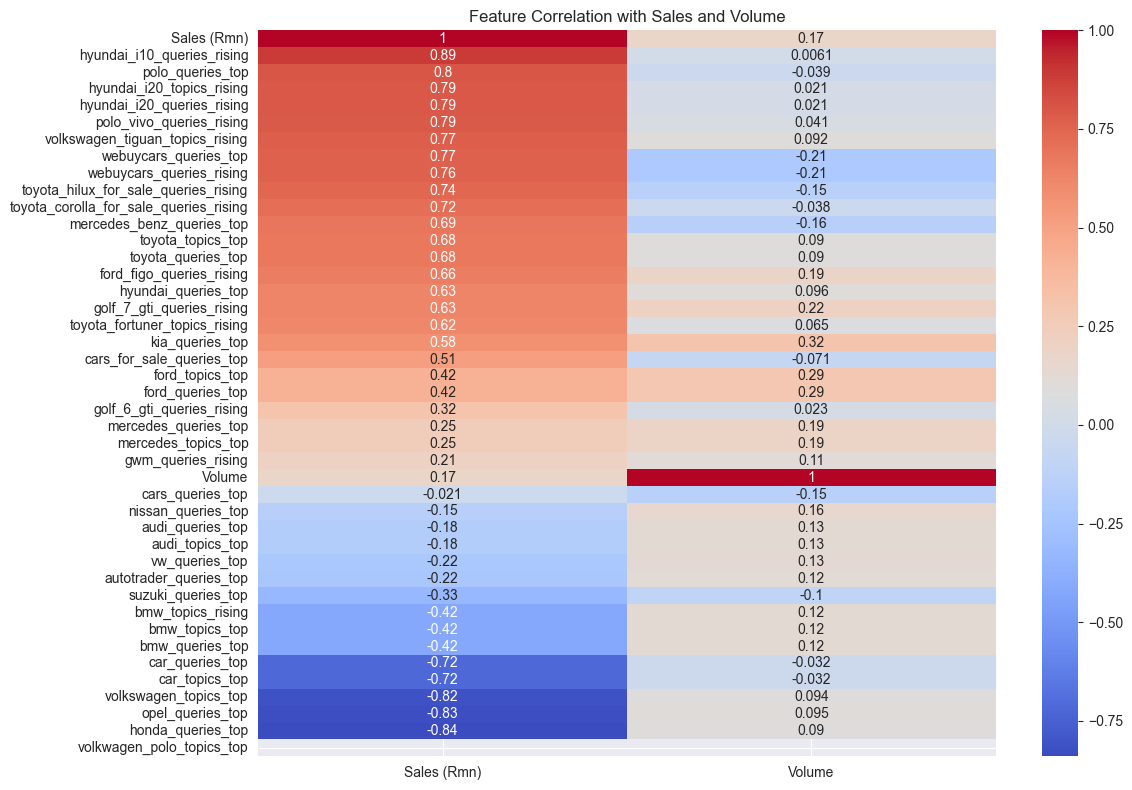

In [49]:
# Check correlations with Sales and Volume
correlation = final.corr(numeric_only=True)

# Heatmap of correlations with Sales and Volume
plt.figure(figsize=(12, 8))
sns.heatmap(correlation[['Sales (Rmn)', 'Volume']].sort_values(by='Sales (Rmn)', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Sales and Volume")
plt.tight_layout()
plt.show()

##### **Interpretation**

**Sales:**
+ There are a lot of strong positive and also negative correlations of the features to sales, which suggests that many of the features are good predictors for sales.

**Volume:**
+ Many features have weak correlation to Voolume which suggest that online search trends are poor predictors of volume compared to sales.

### b. Feature Importance/Selection

In [57]:
# Drop rows with missing data and isolate features/targets
data = final.copy()
X = data.drop(columns=['Sales (Rmn)', 'Volume'])
y1 = data['Sales (Rmn)']  # or 'Volume'
y2 = data['Volume']  # or 'Volume'

# Feature filtering function
def filter_features_by_importance(X, y, threshold=0.001, n_estimators=200, n_repeats=30, random_state=42):
    # Fit RandomForest model
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X, y)

    # Compute Permutation Importance
    pfi = permutation_importance(rf, X, y, n_repeats=n_repeats, random_state=random_state)

    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': pfi.importances_mean
    }).sort_values(by='Importance', ascending=False)

    # Filter features based on threshold
    important_features = importance_df[importance_df['Importance'] > threshold]['Feature']
    X_filtered = X[important_features]

    # Reporting
    print(f"\nNumber of features before filtering: {X.shape[1]}")
    print(f"Number of features after filtering: {X_filtered.shape[1]}")
    print(f"Number of features dropped: {X.shape[1] - X_filtered.shape[1]}")
    print("="*50)
    print("Permutation Feature Importance Table:")
    X_filtered.info()

    return X_filtered


In [51]:
X1 = filter_features_by_importance(X, y1, threshold=0.005)


Number of features before filtering: 41
Number of features after filtering: 9
Number of features dropped: 32
Permutation Feature Importance Table:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 256 entries, 2004-01-31 to 2025-04-30
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   golf_7_gti_queries_rising   256 non-null    int64
 1   golf_6_gti_queries_rising   256 non-null    int64
 2   hyundai_i10_queries_rising  256 non-null    int64
 3   webuycars_queries_rising    256 non-null    int64
 4   kia_queries_top             256 non-null    int64
 5   ford_figo_queries_rising    256 non-null    int64
 6   audi_queries_top            256 non-null    int64
 7   audi_topics_top             256 non-null    int64
 8   webuycars_queries_top       256 non-null    int64
dtypes: int64(9)
memory usage: 28.1 KB


In [52]:
X2 = filter_features_by_importance(X, y2, threshold=0.005)


Number of features before filtering: 41
Number of features after filtering: 33
Number of features dropped: 8
Permutation Feature Importance Table:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 256 entries, 2004-01-31 to 2025-04-30
Data columns (total 33 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   autotrader_queries_top                  256 non-null    int64  
 1   toyota_hilux_for_sale_queries_rising    256 non-null    int64  
 2   kia_queries_top                         256 non-null    int64  
 3   honda_queries_top                       256 non-null    int64  
 4   suzuki_queries_top                      256 non-null    int64  
 5   cars_for_sale_queries_top               256 non-null    int64  
 6   gwm_queries_rising                      256 non-null    int64  
 7   volkswagen_topics_top                   256 non-null    int64  
 8   opel_queries_top                 

### c. Dataset Splits

In [58]:
# Now lets split the datasets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, shuffle=False)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, shuffle=False)

print(f"Train sizes: {len(X1_train)}")
print(f"Test size: {len(X1_test)}")

Train sizes: 204
Test size: 52


## 7. Modelling

The plan is to investigate the effect of search data on the sales and volume using 5 different models. These models are given below:

<table style="width:100%">
  <thead>
    <tr>
      <th>Model</th>
      <th>Description</th>
      <th>Model Category</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>SARIMA</td>
      <td>An extension of the non-seasonal ARIMA model, designed to handle data with seasonal patterns. It captures both short-term and long-term dependencies within the data</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LSSVR</td>
      <td>A variant of the regression version of the Support Vector Machines (SVM). It tries to fit a function that predicts future values while keeping prediction errors within a certain margin (ε-insensitive loss function).</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LSTM</td>
      <td>A type of neural network that excels in this area. Unlike simple models, LSTMs can remember information for long periods, making them ideal for time series tasks where past data influences future values.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>BI-LSTM</td>
      <td>An Extension of the LSTM model that integrates the input information from both past and future time steps. It's like predicting the middle words of a sentence by knowing both its first and last words.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>CNN-LSTM</td>
      <td>Combines the CNNs power of learning local patterns in data, with the LSTMs ability to capture long-term dependencies in sequential data.</td>
      <td>Deep Learning</td>
    </tr>
  </tbody>
</table>

### a. Sales

##### i. SARIMA

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge.

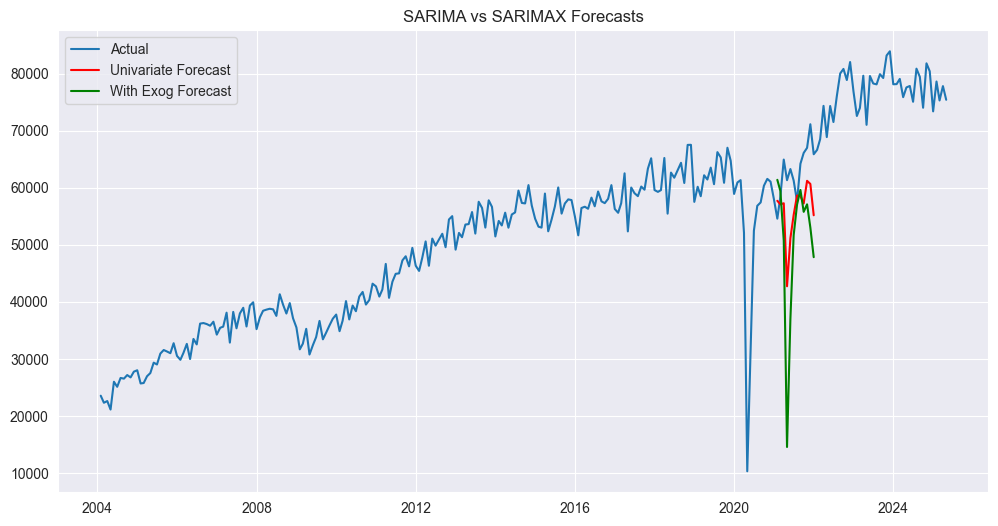

ValueError: Found input variables with inconsistent numbers of samples: [52, 12]

In [59]:
# ===== Univariate SARIMA =====
def train_sarima_univariate(y, order=(1,1,1), seasonal_order=(1,1,1,12), steps=12):
    model = SARIMAX(y, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)

    forecast = results.get_forecast(steps=steps)
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()

    return results, forecast_mean, conf_int

# ===== Multivariate SARIMAX =====
def train_sarima_with_exog(y, exog, order=(1,1,1), seasonal_order=(1,1,1,12), steps=12):
    model = SARIMAX(y, exog=exog, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)

    # Use last available exog values for forecast
    exog_future = exog.iloc[-steps:]
    forecast = results.get_forecast(steps=steps, exog=exog_future)
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()

    return results, forecast_mean, conf_int

# ===== Example Usage =====
# Univariate
sarima_uni, forecast_uni, conf_uni = train_sarima_univariate(y1_train, steps=12)

# Multivariate
sarima_multi, forecast_multi, conf_multi = train_sarima_with_exog(y1_train, X1_train, steps=12)

# ===== Compare Forecasts =====
plt.figure(figsize=(12,6))
plt.plot(y1, label="Actual")
plt.plot(forecast_uni, label="Univariate Forecast", color="red")
plt.plot(forecast_multi, label="With Exog Forecast", color="green")
plt.legend()
plt.title("SARIMA vs SARIMAX Forecasts")
plt.show()

# ===== Evaluate on last 12 months =====
actual = y1_test
mae_uni = mean_absolute_error(actual, forecast_uni)
mae_multi = mean_absolute_error(actual, forecast_multi)

print(f"MAE Univariate: {mae_uni:.2f}")
print(f"MAE Multivariate: {mae_multi:.2f}")


##### ii. LSSVR

##### iii. LSTM

##### iv. Bi-LSTM

##### v. CNN-LSTM